# Detección de Suicidio y Depresión en Textos Usando Modelos de Entrenamiento

## Introducción

En este notebook, exploraremos cómo utilizar modelos de aprendizaje automático para detectar indicios de suicidio y depresión en textos.  Este es un problema importante de salud pública, y la capacidad de identificar tempranamente a personas en riesgo a través del análisis de texto podría ser de gran ayuda para la intervención y prevención.

Nos inspiraremos en notebooks existentes, como el que encontraste en Kaggle ([Suicide and Depression Detection](https://www.kaggle.com/code/chanchal24/suicide-and-depression-detection/input)), para construir un modelo que pueda clasificar textos como indicativos de suicidio/depresión o no.

**Objetivos del Notebook:**

*   Cargar y explorar un dataset de textos etiquetados.
*   Realizar un preprocesamiento de texto adecuado para modelos de Machine Learning.
*   Implementar diferentes técnicas de vectorización de texto (e.g., Bag of Words, TF-IDF).
*   Entrenar y evaluar varios modelos de clasificación (e.g., Regresión Logística, Naive Bayes, SVM, etc.).
*   Evaluar el rendimiento de los modelos utilizando métricas relevantes.
*   Identificar áreas de mejora y posibles expansiones para futuras iteraciones del notebook.

## Carga de Librerías y Dataset

En esta sección, importaremos las librerías necesarias para nuestro análisis y cargaremos el dataset que utilizaremos.

**Librerías Necesarias:**

*   **pandas:** Para manipulación y análisis de datos tabulares.
*   **numpy:** Para operaciones numéricas eficientes.
*   **scikit-learn (sklearn):**  Biblioteca de Machine Learning para modelado, preprocesamiento y evaluación.
*   **nltk (Natural Language Toolkit) o spaCy:** Para tareas de procesamiento de lenguaje natural (NLP) como tokenización, lematización, etc.
*   **matplotlib y seaborn:** Para visualización de datos.

**Carga del Dataset:**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 


# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet') # Para lematización

# Cargamos el dataset
df_extendida = pd.read_csv('Suicide_Detection.csv') 

# Visualizamos las primeras filas para entender la estructura
print(df_extendida.head())

# Información general del dataset
print(df_extendida.info())
df = df_extendida.sample(n=120000, random_state=42)

   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB
None


**Exploración Inicial del Dataset:**

Aquí podemos hacer un análisis rápido para entender las etiquetas y la distribución de los datos.

In [2]:

# Distribución de las etiquetas
print(df['class'].value_counts()) 

# Ejemplo de algunos textos y sus etiquetas
print(df[['text', 'class']].sample(10)) 

class
non-suicide    60039
suicide        59961
Name: count, dtype: int64
                                                     text        class
44321   I’m on the teenagers subreddit even though I’m...  non-suicide
209852  StupidI can't live without her... I don't want...      suicide
115209  No one's going to read this unless its Hot.The...      suicide
127930  I recorded spy communication https://youtu.be/...  non-suicide
166837  I split up with my loving, caring boyfriend. I...      suicide
65102   Living with chronic illness and feeling hopele...      suicide
110519  No one will ever know the real me.I had writte...      suicide
87639   Is cyberpunk worth playing through on playstat...  non-suicide
68552   LostI can't die because I don't want to hurt t...      suicide
10284   Today I got rejected. I haven’t cried in years...  non-suicide


## Análisis Exploratorio de Datos (EDA)

En esta sección, profundizaremos en el análisis de los datos para entender mejor las características de los textos y las etiquetas.  Podemos hacer lo siguiente:

*   **Distribución de Clases:** Visualizar la proporción de cada clase en el dataset (¿está balanceado?).
*   **Longitud de los Textos:**  Analizar la longitud de los textos (número de palabras, caracteres) para cada clase. ¿Hay diferencias?
*   **Palabras Comunes:** Identificar las palabras más frecuentes en cada clase.  Esto puede dar ideas sobre qué palabras son más indicativas de cada categoría.
*   **Nube de Palabras (Word Clouds):**  Visualizar las palabras más importantes de forma gráfica.

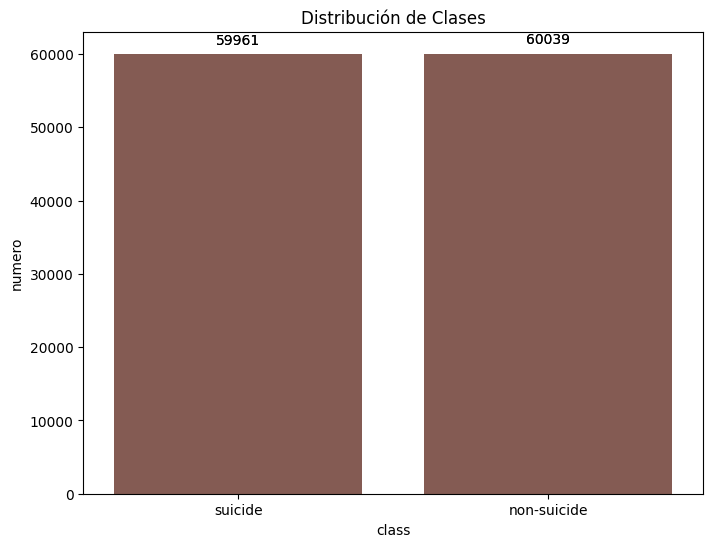

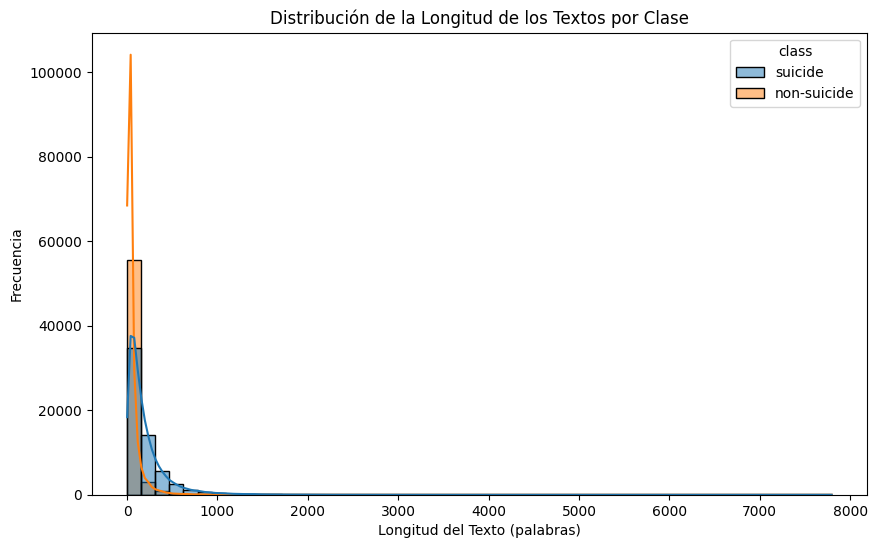

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Distribución de clases 
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df) 
plt.title('Distribución de Clases')
plt.ylabel('numero')
# Agregar etiquetas específicas a la distribución de clases
for p in sns.countplot(x='class', data=df).patches:
    sns.countplot(x='class', data=df).annotate(format(p.get_height(), '.0f'), 
                                               (p.get_x() + p.get_width() / 2., p.get_height()), 
                                               ha = 'center', va = 'center', 
                                               xytext = (0, 10), 
                                               textcoords = 'offset points')
plt.show()

# Longitud de los textos (en palabras)
df['longitud_texto'] = df['text'].apply(lambda texto: len(texto.split())) 

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='longitud_texto', hue='class', kde=True, bins=50) 
plt.title('Distribución de la Longitud de los Textos por Clase')
plt.xlabel('Longitud del Texto (palabras)')
plt.ylabel('Frecuencia')
plt.show()


      word   count
41    just  134264
16     don   97928
47    like   94190
91    want   76583
43    know   68091
20    feel   63500
46    life   63241
90      ve   62631
61  people   48902
83    time   45093


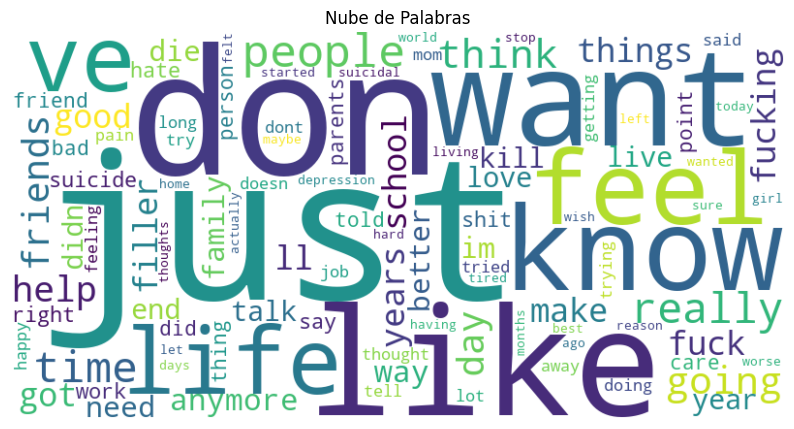

In [4]:
# Vectorización de texto usando CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=100)
X_counts = vectorizer.fit_transform(df['text'])
word_counts = X_counts.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()

# Crear un DataFrame con las palabras y sus frecuencias
word_freq_df = pd.DataFrame({'word': words, 'count': word_counts})
word_freq_df = word_freq_df.sort_values(by='count', ascending=False)

# Mostrar las 10 palabras más comunes
print(word_freq_df.head(10))

# Generar una nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(words, word_counts)))

# Visualizar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras')
plt.show()

## Preprocesamiento de Texto
 
Realizamos el procedimiento normal, donde esta:

*   **Convertir a Minúsculas (Lowercasing):**  Unificar el texto convirtiendo todo a minúsculas.
*   **Eliminar Puntuación:**  Remover signos de puntuación que no aportan significado al modelo.
*   **Eliminar Stop Words:**  Eliminar palabras comunes muy frecuentes que generalmente no distinguen entre clases (e.g., "el", "la", "y", "que").  NLTK y spaCy tienen listas de stop words en varios idiomas, sin embargo lo hicimos en ingles logicamente por el csv.
*   **Lematización o Stemming:** Reducir las palabras a su forma base (lema o raíz) para tratar diferentes formas de la misma palabra como una sola (e.g., "corriendo", "corrió", "correr" -> "correr").  Lematización suele ser más precisa pero computacionalmente más costosa que stemming.

In [5]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words_english = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def preprocess_text(text):
    # 1. Minúsculas
    text = text.lower()
    # 2. Eliminar puntuación
    text = ''.join([char for char in text if char not in string.punctuation])
    # 3. Tokenización (dividir en palabras) - Usamos split() aquí para simplicidad, pero posiblemente en versiones posteriores usaremos nltk.word_tokenize() como opcion mas especializada
    tokens = text.split()
    # 4. Eliminar Stop Words
    tokens = [word for word in tokens if word not in stop_words_english] # Adaptamos la lista de stop words según el idioma, preliminarmente en ingles
    # 5. Lematización (o Stemming)
    tokens = [lemmatizer.lemmatize(word) for word in tokens] 
    return ' '.join(tokens) # Volver a unir los tokens en un texto

# Aplica el preprocesamiento a la columna de texto
df['texto_preprocesado'] = df['text'].apply(preprocess_text) 

print(df[['text', 'texto_preprocesado']].head()) # Visualiza el antes y después del preprocesamiento

                                                     text  \
74414   I Don't know?7? Months self harm free and the ...   
149516  I HAVE TO START BECOMING RICH I HAVE TO START ...   
12484   A poem (haiku) for u/Me-Game-Dev hi, hello hel...   
14043   I've honestly got no idea what to do anymore.I...   
30673   Do you ever just cry? Like you just think abou...   

                                       texto_preprocesado  
74414   dont know7 month self harm free urge get stron...  
149516  start becoming rich start company become 16 af...  
12484   poem haiku umegamedev hi hello hello stop fuck...  
14043   ive honestly got idea anymoreit feel everyone ...  
30673   ever cry like think unfair life cry cant cry e...  


## Vectorización de Texto

Para que los modelos de Machine Learning puedan trabajar con texto, necesitamos convertirlo a una forma numérica.  Las técnicas comunes son:

*   **Bag of Words (BoW):**  Crea un vocabulario de todas las palabras únicas en el dataset.  Cada documento se representa como un vector donde cada posición corresponde a una palabra del vocabulario y el valor es la frecuencia de esa palabra en el documento.
*   **TF-IDF (Term Frequency-Inverse Document Frequency):** Similar a BoW, pero pondera las palabras según su frecuencia en el documento y su frecuencia inversa en todo el corpus.  Palabras que son frecuentes en un documento pero raras en el resto del corpus reciben mayor peso.

Usaremos `TfidfVectorizer` de scikit-learn, que es una opción popular y suele funcionar bien. 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Puedes ajustar max_features
X = tfidf_vectorizer.fit_transform(df['texto_preprocesado'])
y = df['class'] 

print("Forma de la matriz TF-IDF:", X.shape)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify=y para mantener proporciones de clase en train/test

Forma de la matriz TF-IDF: (120000, 5000)


## Modelado

Ahora vamos a entrenar algunos modelos de clasificación para predecir si un texto indica suicidio/depresión o no.  Probaremos con:

*   **Regresión Logística**
*   **Naive Bayes (MultinomialNB)** -  Funciona bien con datos de texto vectorizados (frecuencias de palabras).
*   **Support Vector Machine (SVM) - Lineal** -  También suele ser efectivo en clasificación de texto.


Entrenando modelo: Regresión Logística 🚀


c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


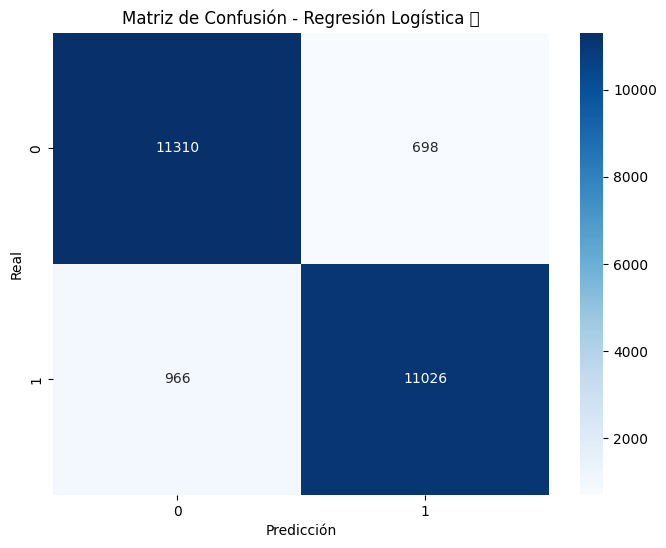


Entrenando modelo: Naive Bayes 🚀


c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


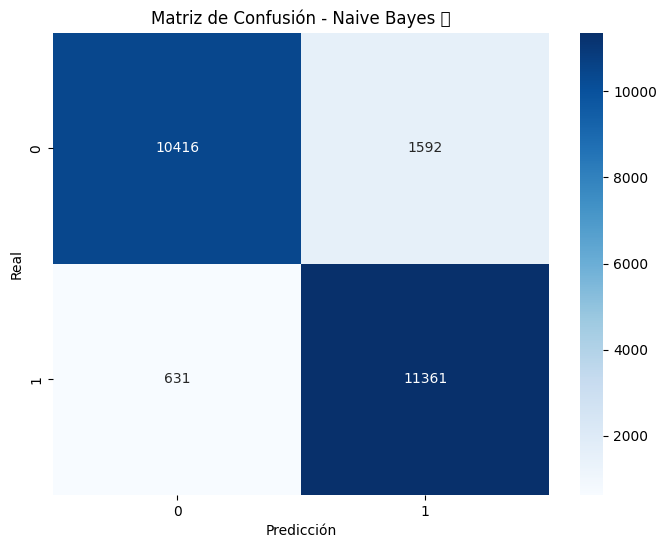


Entrenando modelo: XGBoost 🌳 🚀


c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:49:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


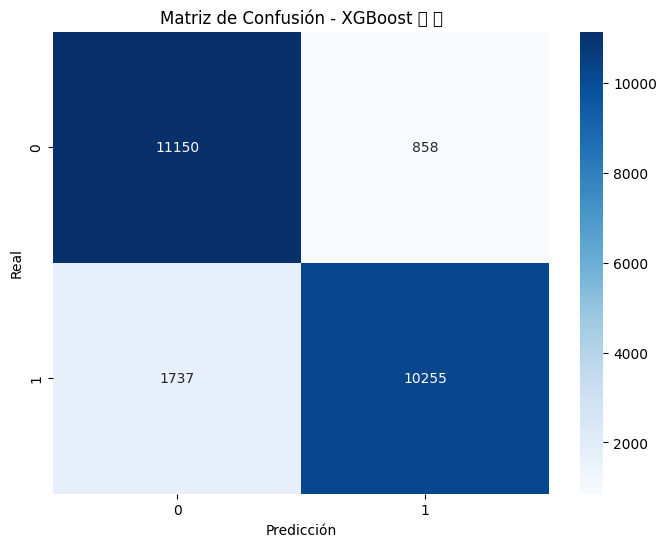


Entrenando modelo: Random Forest 🌲 🚀


c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


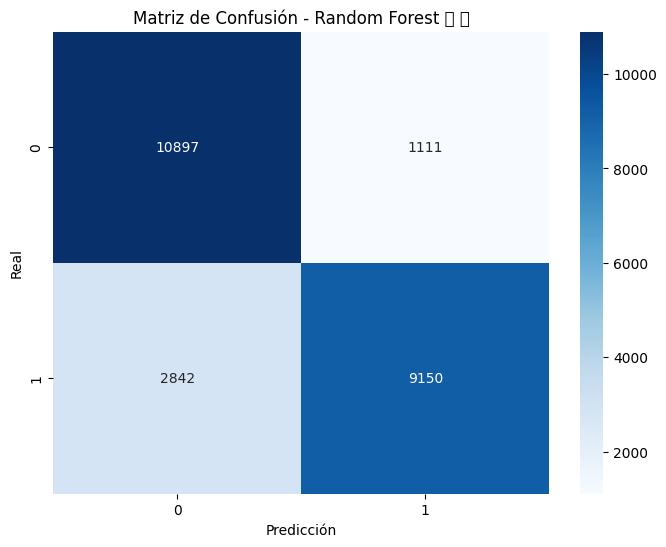

In [8]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Codificar las etiquetas de clase
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Definición de modelos 🤖
modelos = {
    'Regresión Logística': LogisticRegression(max_iter=1000), # Aumenta max_iter si es necesario
    'Naive Bayes': MultinomialNB(),
    'XGBoost 🌳': xgb.XGBClassifier(
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    'Random Forest 🌲': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
}

# Entrenamiento y evaluación 📈
resultados = {}
for nombre_modelo, modelo in modelos.items():
    print(f"\nEntrenando modelo: {nombre_modelo} 🚀")
    modelo.fit(X_train, y_train_encoded)
    y_pred = modelo.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test_encoded, y_pred)
    reporte = classification_report(y_test_encoded, y_pred)
    matriz_confusion = confusion_matrix(y_test_encoded, y_pred)
    
    resultados[nombre_modelo] = {
        'accuracy': accuracy,
        'reporte': reporte,
        'matriz_confusion': matriz_confusion,
        'modelo': modelo
    }
    
    # Visualización de matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre_modelo} 📊')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Guardar los modelos entrenados con pickle
for nombre_modelo, res in resultados.items():
    with open(f'modelo_depresion_{nombre_modelo.lower().replace(" ", "_").replace("🌳", "xgboost").replace("🌲", "random_forest")}.pkl', 'wb') as f:
        pickle.dump(res['modelo'], f)

# Guardar el vectorizador TF-IDF con pickle
with open('tfidf_vectorizador_depresion.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

## Evaluación del Modelo y Conclusiones

En esta sección, analizaremos los resultados de los modelos y sacaremos conclusiones.  Observaremos el accuracy, el reporte de clasificación (que incluye precisión, recall, F1-score) y la matriz de confusión para entender el rendimiento de cada modelo en detalle.

**Puntos a Considerar en la Evaluación:**

*   **Accuracy:**  ¿Qué tan bien clasifica el modelo en general?
*   **Precisión (Precision):**  De todas las predicciones positivas, ¿cuántas fueron realmente correctas?  Importante para minimizar falsos positivos.
*   **Recall (Exhaustividad):** De todos los casos positivos reales, ¿cuántos identificó correctamente el modelo? Importante para minimizar falsos negativos (especialmente en este contexto sensible).
*   **F1-score:**  Promedio armónico de precisión y recall.  Útil cuando hay un desbalance entre precisión y recall.
*   **Matriz de Confusión:**  Muestra el número de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos, dando una visión más detallada de los errores del modelo.

**Conclusiones Iniciales:**

*   ¿Qué modelo funcionó mejor en términos de accuracy y otras métricas relevantes?
*   ¿Hay algún modelo que parezca mejor en minimizar falsos negativos (si eso es prioritario)?
*   ¿Dónde fallan los modelos? (Mirar la matriz de confusión).
*   ¿Qué podemos mejorar en futuras iteraciones? (Preprocesamiento, vectorización, modelos, más datos, etc.)

## Próximos Pasos y Posibles Expansiones

Este notebook es un punto de partida.  Aquí hay algunas ideas para expandirlo y mejorarlo:

*   **Mejorar el Preprocesamiento:**
    *   Probar diferentes técnicas de lematización/stemming o usar spaCy para un preprocesamiento más avanzado.
    *   Manejar emojis, hashtags, menciones (si son relevantes en tu dataset).
    *   Corregir errores ortográficos (si es posible y relevante).
*   **Experimentar con Diferentes Vectorizaciones:**
    *   Probar `CountVectorizer` (Bag of Words).
    *   Usar n-gramas (e.g., bi-gramas, tri-gramas) en la vectorización para capturar frases.
    *   Considerar Word Embeddings (Word2Vec, GloVe, FastText) para representar las palabras de forma más semántica (esto sería un paso más avanzado).
*   **Probar Más Modelos:**
    *   Random Forest, Gradient Boosting Machines (como XGBoost, LightGBM).
    *   Redes Neuronales (para un enfoque más profundo, pero requiere más datos y ajuste).
*   **Ajuste de Hiperparámetros:**
    *   Usar técnicas como Grid Search o Random Search para encontrar los mejores parámetros para los modelos.
*   **Feature Engineering Adicional:**
    *   Extraer características adicionales del texto, como análisis de sentimiento, uso de ciertas palabras clave, etc.
*   **Recopilación de Más Datos:**  Si el rendimiento no es suficiente, más datos etiquetados suelen ayudar.
*   **Manejo de Desbalance de Clases:** Si las clases están muy desbalanceadas, usar técnicas de sobremuestreo (oversampling) o submuestreo (undersampling).
*   **Validación Cruzada:**  Usar validación cruzada para una evaluación más robusta del rendimiento del modelo.